In [414]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
%matplotlib inline
pd.set_option('display.max_colwidth',999)

### Make movement dictionary to use in vectorizor and a relationship dictionary to relate movement with movement class

In [166]:
movements = pd.read_csv('movements.csv', index_col='Unnamed: 0')
add_moves = [{'movement':'double-under','frequency':153,'move_class':'Monostructural','Equipment':'jump rope'},{'movement':'squat','frequency':63,'move_class':'Gymnastics','Equipment':'body'}]
am = pd.DataFrame(add_moves)
new_move = pd.concat([movements,am], ignore_index=True)
new_move_dict = new_move[['movement','move_class','Equipment']].to_dict(orient='records')
move_dict = new_move.movement.to_dict()
res = dict((v,k) for k,v in move_dict.iteritems())
relate_dict = {}
equip_dict = {}
for row in new_move_dict:
    relate_dict[row['movement']] = row['move_class']
    equip_dict[row['movement']] = row['Equipment']


In [167]:
eq_dict = new_move.Equipment.to_dict()
other_dict = dict((v,k) for k,v in eq_dict.iteritems())
bar = [k for k in other_dict.iterkeys()]
for i,k in enumerate(bar):
    other_dict[k]=i


### Read in initial data from Beyond the Whiteboard and locate the rows that represent workouts for time or for reps

In [390]:
df = pd.read_csv('data.csv')
df1 = df.loc[(df['Work performed'] > 0) & (df['Work time'] > 0),:].copy()

In [391]:
df1.reset_index(drop = True)

,Date,Workout,Result,Prescribed,Pukie,Work performed,Work time,Formatted Result,Notes,Description
0,2017-04-04,"5 RFT: Power Cleans, Walking Lunges, and Thrusters",3.990000e+05,True,False,42039,399000.0,6 mins 39 secs,Went out too hot,"5 rounds of:\n12 Power Cleans, 65 lbs\n6 Walking Lunges, 65 lbs\n3 Thrusters, 65 lbs"
1,2017-04-02,Cindy,1.113300e+01,True,False,88204,1200000.0,11 rounds + 2 Pull-ups | 332 reps,NaN,20:00 AMRAP:\n5 Pull-ups\n10 Push-ups\n15 Air Squats
2,2017-03-28,21-15-9: Push Press and Box Jumps,4.190000e+05,True,False,21197,419000.0,6 mins 59 secs,"Step ups, got a set of 13 pp on the first round","21-15-9 reps of:\nPush Press, 95 lbs\nBox Jump, 20 in"
3,2017-03-26,"Row : 3x 1 km, rest 3 mins",7.715000e+05,True,False,93741,771500.0,12 mins 51.5 secs,NaN,"Intervals : rest 3 mins\nRow, 1 km | 4:11.9\nRow, 1 km | 4:19.3\nRow, 1 km | 4:20.3"
4,2017-03-24,CrossFit Games Open 17.5,9.820000e+05,True,False,66793,982000.0,16 mins 22 secs,"All thrusters unbroken, 5 of the rounds of dubs unbroken","10 rounds of:\n9 Thrusters, 65 lbs\n35 Double Unders"
5,2017-03-22,Every 1:30 for 10:30: Front Squat,8.572896e+02,True,False,5848,630000.0,1890 lbs,NaN,Every 1:30 for 10:30:\n2 Front Squats | 135 lbs\n2 Front Squats | 135 lbs\n2 Front Squats | 135 lbs\n2 Front Squats | 135 lbs\n2 Front Squats | 135 lbs\n2 Front Squats | 135 lbs\n2 Front Squats | 135 lbs
6,2017-03-22,AMRAP 5 mins: Squat Cleans and AbMat Sit-ups,3.810000e+00,True,False,29387,300000.0,3 rounds + 7 Squat Cleans + 13 AbMat Sit-ups | 104 reps,NaN,"5:00 AMRAP:\n7 Squat Cleans, 75 lbs\n21 AbMat Sit-ups"
7,2017-03-22,AMRAP 5 mins: Hanging Knee Raises and Push Press,3.000000e+00,True,False,2780,300000.0,3 rounds | 84 reps,NaN,"5:00 AMRAP:\n21 Hanging Knee Raises\n7 Push Press, 75 lbs"
8,2017-03-22,AMRAP 5 mins: Wall Balls and Pull-ups,1.600000e+00,True,False,10193,300000.0,1 round + 10 Wall Balls + 3 Pull-ups | 38 reps,Singles on pull ups,"5:00 AMRAP:\n10 Wall Balls, 14 lbs\n15 Pull-ups"
9,2017-03-21,AMRAP 10 mins: Lateral Burpee (Over Barbell)s and Power Snatches,2.833000e+00,True,False,44381,600000.0,2 rounds + 15 Lateral Burpee (Over Barbell)s + 10 Power Snatches | 85 reps,NaN,"10:00 AMRAP:\n15 Lateral Burpee (Over Barbell)s\n15 Power Snatches, 75 lbs"


In [392]:
df1['Work performed'].median()

31512.5

### Create functions to feed into Feature Union and Pipeline

In [393]:
def base_features(df):
    return df[['Work time']]

base_features_tf = FunctionTransformer(base_features, validate=False)

In [394]:
def get_movements(df):
    move_in_work = []
    for w in [x for x in df['Description']]:
        moves = []
        row = {}
        for m in new_move.movement:
            if m in w.lower():
                moves.append(m)
        row['move'] = ', '.join(moves)
        move_in_work.append(row)
    return pd.DataFrame(move_in_work)['move']

get_movements_tf = FunctionTransformer(get_movements, validate=False)
        

In [395]:
def equipment_used(cell):
    equipment_used = []
    equip_list = cell.split(', ')
    for x in equip_list:
        if x in equip_dict:
            equipment_used.append(equip_dict[x])
    return ', '.join(sorted(set(equipment_used))) 


In [396]:
get_movements(df1).shape

(742L,)

In [397]:
get_equip(df1).shape

(742L,)

In [398]:
def get_equip(df):
    return pd.DataFrame(get_movements(df).apply(equipment_used))['move']
    
get_equip_tf = FunctionTransformer(get_equip, validate=False)

In [399]:
def mgw_breakdown(cell):
    mgw = []
    move_list = cell.split(', ')
    for x in move_list:
        if x in relate_dict:
            mgw.append(relate_dict[x][0])
    return ''.join(sorted(set(mgw)))

In [400]:
def get_move_class(df):
    breakdown = pd.DataFrame(get_movements(df).apply(mgw_breakdown)) 
    for let in ['G','M','W']:
        breakdown[let] = breakdown['move'].apply(lambda x: 1 if re.search(let,x) else 0)
    return breakdown[['G','M','W']]

get_move_class_tf = FunctionTransformer(get_move_class, validate=False)

In [401]:
def time_or_reps(df):
    time_or_reps = pd.DataFrame(df['Formatted Result'].apply(lambda x: 'Time' if re.search(r'(min|sec)', x) else 'Reps'))
    return pd.get_dummies(time_or_reps, prefix='For')

time_or_reps_tf = FunctionTransformer(time_or_reps, validate=False)

In [402]:
def is_prescribed(df):
    return df['Prescribed'].apply(int).to_frame()

is_prescribed_tf = FunctionTransformer(is_prescribed, validate=False)    

In [403]:
def get_year(df):
    years = pd.Categorical(pd.to_datetime(df['Date']).dt.year, categories = range(2011,2018))
    return pd.get_dummies(years, columns=['Date'], prefix='Year')

get_year_tf = FunctionTransformer(get_year, validate=False)

In [404]:
def get_month(df):
    months = pd.DataFrame(pd.to_datetime(df['Date']).dt.month)
    return pd.get_dummies(months, columns=['Date'], prefix='Month')

get_month_tf = FunctionTransformer(get_month, validate=False)

In [405]:
equip_pipeline = Pipeline([
    ('get_equip', get_equip_tf),
    ('eq_vect', CountVectorizer(vocabulary=other_dict)),
    ('eq_nonsparse',FunctionTransformer(lambda X: X.toarray(), validate=False)) 
])

In [406]:
vector_pipeline = Pipeline([
    ('get_movements', get_movements_tf),
    ('vect', CountVectorizer(vocabulary=res)),
    ('nonsparse',FunctionTransformer(lambda X: X.toarray(), validate=False)) 
])

In [439]:
features = FeatureUnion([
    #('get_month', get_month_tf),
    #('get_year', get_year_tf),
    ('equip_pipeline', equip_pipeline),
    ('is_prescribed', is_prescribed_tf),
    ('time_or_reps', time_or_reps_tf),
    ('get_move_class', get_move_class_tf),
    ('vector_pipeline', vector_pipeline),
    ('base_features', base_features_tf)
])

In [444]:
pipe = Pipeline([
    ('features', features),
    ('ss', StandardScaler()),
    #('lr', LinearRegression(fit_intercept=False, normalize=True))
    #('rf', RandomForestRegressor())
    ('gb', GradientBoostingRegressor(loss='lad',max_depth=5))
    #('dt', DecisionTreeRegressor())
])

In [443]:


kf = KFold(n_splits=3, shuffle= True ,random_state=2003)

#cross_val_score(pipe, df1, y=df1['Work performed'], cv=kf, verbose=True).mean()
params = {
    'gb__loss': ['ls','lad'],
    'gb__n_estimators': [100,200,300],
    'gb__max_depth': [3,4,5]
}
gs = GridSearchCV(pipe, param_grid=params, cv=kf)
gs.fit( df1, df1['Work performed'])
print gs.best_score_
print gs.best_params_

0.723401741422
{'gb__loss': 'lad', 'gb__n_estimators': 100, 'gb__max_depth': 5}


In [445]:
X_train, X_test, y_train, y_test = train_test_split(df1, df1['Work performed'], test_size =0.2,  random_state=2008)

In [446]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('get_year', FunctionTransformer(accept_sparse=False,
          func=<function get_year at 0x0000000012718D68>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y=False, validate=False)), ('equip_pipeline', Pipeline...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))])

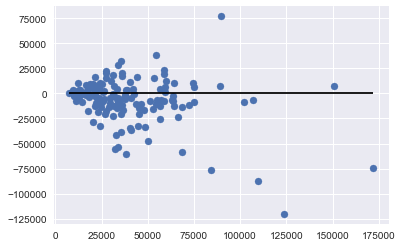

In [447]:
pred = pipe.predict(X_test)

plt.scatter(pred, pred - y_test)
plt.hlines(y = 0, xmin= pred.min(), xmax=pred.max())